In [2]:
!pip install --upgrade --force-reinstall pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.9 MB/s eta 0:00:00


Solving Example 1...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/1500, Loss: 0.936409592628479
Epoch 10/1500, Loss: 0.47478288412094116
Epoch 20/1500, Loss: 0.8293030858039856
Epoch 30/1500, Loss: 1.0991305112838745
Epoch 40/1500, Loss: 1.0229456424713135
Epoch 50/1500, Loss: 0.23666520416736603
Epoch 60/1500, Loss: 0.42264455556869507
Epoch 70/1500, Loss: 0.3734391927719116
Epoch 80/1500, Loss: 0.06806747615337372
Epoch 90/1500, Loss: 0.20727017521858215
Epoch 100/1500, Loss: 0.12571460008621216
Epoch 110/1500, Loss: 0.22875341773033142
Epoch 120/1500, Loss: 0.01971268840134144
Epoch 130/1500, Loss: 0.007534583564847708
Epoch 140/1500, Loss: 0.07368578761816025
Epoch 150/1500, Loss: 0.03982459753751755
Epoch 160/1500, Loss: 0.039689723402261734
Epoch 170/1500, Loss: 0.06353551894426346
Epoch 180/1500, Loss: 0.04286123812198639
Epoch 190/1500, Loss: 0.06490208208560944
Epoch 200/1500, Loss: 0.04222763329744339
Epoch 210/1500, Loss: 0.009996394626796246
Epoch 

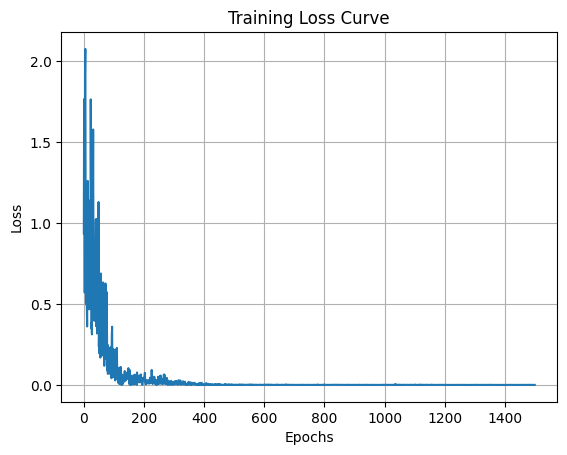

Solving Example 2...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/1500, Loss: 0.28093641996383667
Epoch 10/1500, Loss: 0.7969850301742554
Epoch 20/1500, Loss: 0.21341922879219055
Epoch 30/1500, Loss: 0.12405751645565033
Epoch 40/1500, Loss: 1.4059040546417236
Epoch 50/1500, Loss: 1.2329587936401367
Epoch 60/1500, Loss: 0.27378761768341064
Epoch 70/1500, Loss: 0.009711278602480888
Epoch 80/1500, Loss: 0.19230055809020996
Epoch 90/1500, Loss: 0.04158678650856018
Epoch 100/1500, Loss: 0.024075264111161232
Epoch 110/1500, Loss: 0.02316051535308361
Epoch 120/1500, Loss: 0.009281093254685402
Epoch 130/1500, Loss: 0.0004422455094754696
Epoch 140/1500, Loss: 0.0001754617551341653
Epoch 150/1500, Loss: 0.04646826535463333
Epoch 160/1500, Loss: 0.008378657512366772
Epoch 170/1500, Loss: 1.9640667233034037e-05
Epoch 180/1500, Loss: 0.0019161507952958345
Epoch 190/1500, Loss: 0.00020464477711357176
Epoch 200/1500, Loss: 0.003658296074718237
Epoch 210/1500, Loss: 0.0002301

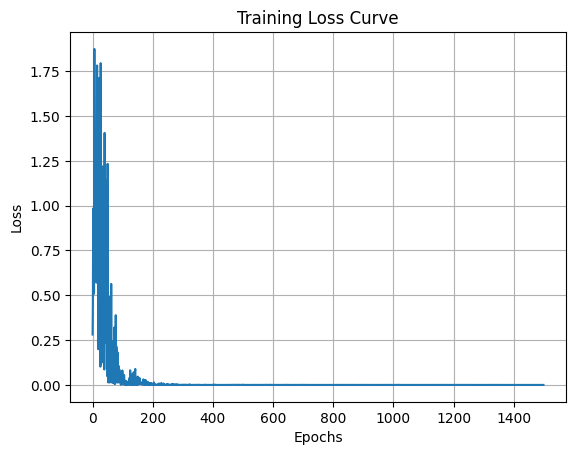

Plotting results...


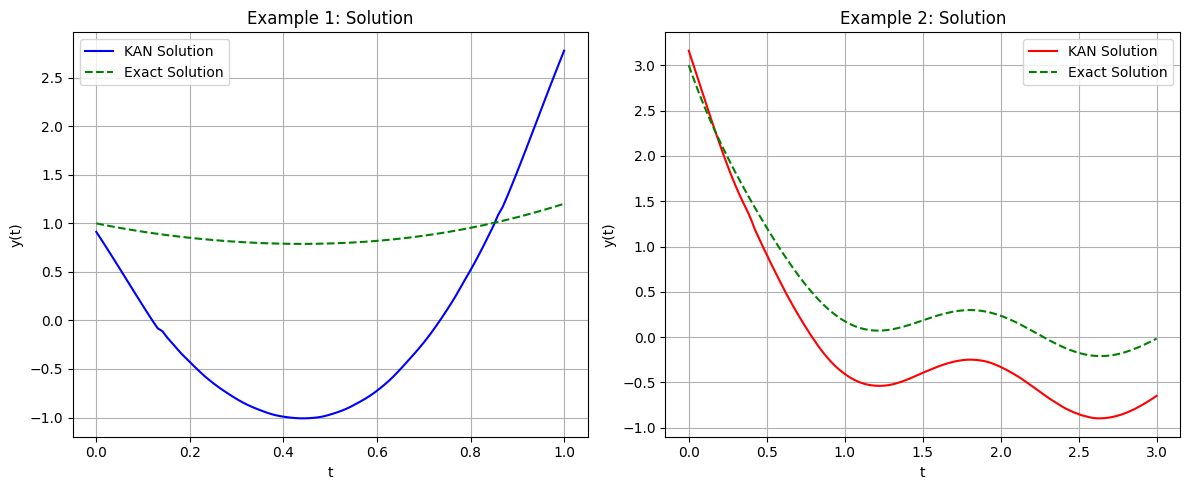

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from kan import MultKAN

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from kan import MultKAN

def train_model(model, dataset, optimizer, epochs, loss_fn, patience=50):
    model.train()
    train_input = dataset['train_input']
    train_label = dataset['train_label']

    # Early stopping setup
    best_loss = float('inf')
    counter = 0
    losses = []

    # Use DataLoader for mini-batch training
    batch_size = 10
    train_data = TensorDataset(train_input, train_label)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Calculate steps per epoch
    steps_per_epoch = len(train_loader)

    # Use ReduceLROnPlateau scheduler to adjust learning rate based on loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.5)


    # Apply gradient clipping, scheduler, and batch normalization
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        epoch_loss = 0  # Initialize epoch loss

        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()
            epoch_loss += loss.item()  # Accumulate batch loss

        avg_epoch_loss = epoch_loss / len(train_loader)  # Calculate average epoch loss
        scheduler.step(avg_epoch_loss)  # Update the learning rate using epoch loss

        # # Early stopping and loss tracking
        # if loss.item() < best_loss:
        #     best_loss = loss.item()
        #     counter = 0
        # else:
        #     counter += 1
        # if counter >= patience:
        #     print(f"Early stopping at epoch {epoch}")
        #     break


        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

        losses.append(loss.item())

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()

    return model

def solve_example1():
    """
    Solve the first ODE example with the correct training targets.
    """
    # Define KAN model with more complexity
    model = MultKAN(
        width=[1, 20, 1],   # Define the architecture with input, hidden, and output layers
        grid=30,                # Increased grid resolution for better function representation
        k=5,                    # Set spline order for finer approximation
        mult_arity=2,           # Set multiplication arity (can adjust based on network design)
        noise_scale=0.1,        # Reduced noise scale for more stable training
        scale_base_mu=0.0,      # Base function scaling mean
        scale_base_sigma=0.5,   # Base function scaling standard deviation
        base_fun=torch.nn.Sigmoid(),  # Chosen activation function
        symbolic_enabled=True,  # Enable symbolic regression (or set to False if not needed)
        affine_trainable=True,  # Affine parameters are trainable
        grid_eps=0.01,          # Fine-tuned epsilon for adaptive grid
        grid_range=[-1, 1],     # Grid range
        sp_trainable=True,      # Enable training of spline magnitudes
        sb_trainable=True,      # Enable training of base function magnitudes
        sparse_init=True,       # Enable sparse initialization
        auto_save=True,         # Enable automatic saving of model checkpoints
        first_init=True,        # Initial configuration flag
        ckpt_path='./model',    # Path for model checkpoints
        state_id=0,             # Initial state ID for checkpointing
        round=0,                # Round for rewinding if necessary
        device='cpu'            # Define the device ('cpu' or 'cuda')
    )

    # Define exact solution
    def exact_solution(t):
        return (np.exp(-t**2 / 2) + t**5 + t**3 + t**2) / (t**3 + t + 1)

    # Training data
    t_train = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_train = exact_solution(t_train.numpy())
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # Normalize data using training statistics
    t_train_mean = t_train.mean()
    t_train_std = t_train.std()
    t_train = (t_train - t_train_mean) / t_train_std
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std

    dataset = {
        'train_input': t_train,
        'train_label': y_train
    }

    # Update the optimizer and loss function in your training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    loss_fn = torch.nn.MSELoss()

    # Train the model
    model = train_model(model, dataset, optimizer, epochs=1500, loss_fn=loss_fn, patience=200)

    # Evaluate and plot results
    t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
    t_eval_normalized = (t_eval - t_train_mean) / t_train_std
    y_pred = model(t_eval_normalized).detach().numpy()
    y_exact = exact_solution(t_eval.numpy())

    return t_eval.numpy(), y_pred, y_exact


def solve_example2():
    """
    Solve the second ODE example with the correct training targets.
    """
    # Define KAN model with more complexity
    model = MultKAN(
        width=[1, 20, 1],   # Define the architecture with input, hidden, and output layers
        grid=30,                # Increased grid resolution for better function representation
        k=5,                    # Set spline order for finer approximation
        mult_arity=2,           # Set multiplication arity (can adjust based on network design)
        noise_scale=0.1,        # Reduced noise scale for more stable training
        scale_base_mu=0.0,      # Base function scaling mean
        scale_base_sigma=0.5,   # Base function scaling standard deviation
        base_fun=torch.nn.Sigmoid(),  # Chosen activation function
        symbolic_enabled=True,  # Enable symbolic regression (or set to False if not needed)
        affine_trainable=True,  # Affine parameters are trainable
        grid_eps=0.01,          # Fine-tuned epsilon for adaptive grid
        grid_range=[-1, 1],     # Grid range
        sp_trainable=True,      # Enable training of spline magnitudes
        sb_trainable=True,      # Enable training of base function magnitudes
        sparse_init=True,       # Enable sparse initialization
        auto_save=True,         # Enable automatic saving of model checkpoints
        first_init=True,        # Initial configuration flag
        ckpt_path='./model',    # Path for model checkpoints
        state_id=0,             # Initial state ID for checkpointing
        round=0,                # Round for rewinding if necessary
        device='cpu'            # Define the device ('cpu' or 'cuda')
    )

    # Define exact solution
    def exact_solution(t):
        return np.sin(4 * t) / 5 + np.cos(4 * t) / 10 + 2.9 * np.exp(-2 * t)

    # Training data
    t_train = torch.linspace(0, 3, 150).reshape(-1, 1)
    y_train = exact_solution(t_train.numpy())
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # Normalize data using training statistics
    t_train_mean = t_train.mean()
    t_train_std = t_train.std()
    t_train = (t_train - t_train_mean) / t_train_std
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std

    dataset = {
        'train_input': t_train,
        'train_label': y_train
    }

    # Update the optimizer and loss function in your training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    loss_fn = torch.nn.MSELoss()

    # Train the model
    model = train_model(model, dataset, optimizer, epochs=1500, loss_fn=loss_fn, patience=200)

    # Evaluate and plot results
    t_eval = torch.linspace(0, 3, 150).reshape(-1, 1)
    t_eval_normalized = (t_eval - t_train_mean) / t_train_std
    y_pred = model(t_eval_normalized).detach().numpy()
    y_exact = exact_solution(t_eval.numpy())

    return t_eval.numpy(), y_pred, y_exact



def plot_results(t1, y1, y1_exact, t2, y2, y2_exact):
    """
    Plot the results for both examples.
    """
    plt.figure(figsize=(12, 5))

    # Plot Example 1
    plt.subplot(1, 2, 1)
    plt.plot(t1, y1, 'b-', label='KAN Solution')
    plt.plot(t1, y1_exact, 'g--', label='Exact Solution')
    plt.title('Example 1: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    # Plot Example 2
    plt.subplot(1, 2, 2)
    plt.plot(t2, y2, 'r-', label='KAN Solution')
    plt.plot(t2, y2_exact, 'g--', label='Exact Solution')
    plt.title('Example 2: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


def main():
    print("Solving Example 1...")
    t1, y1, y1_exact = solve_example1()

    print("Solving Example 2...")
    t2, y2, y2_exact = solve_example2()

    print("Plotting results...")
    plot_results(t1, y1, y1_exact, t2, y2, y2_exact)


if __name__ == "__main__":
    main()
